

# Домашнее задание
## Чем лучше бустить? Тестируем алгоритмы бустинга в бою.


Градиентный бустинг - метод ансамблирования, который последовательно строит деревья решений (базовые алгоритмы в общем случае) так, чтобы каждое следующее дерево исправляло ошибку предыдущих.

При этом мы строим **неглубокие деревья** максимальной высоты, обычно не глубже 3-7.

**Вопрос:** как вы думаете почему?

Общее число деревьев это гиперпараметр $B$.

Помимо этого часто мы хотим, чтобы каждое следующее дерево исправляло лишь часть ошибки. Для этого мы используем гиперпараметр $\eta$. Поскольку на $\eta$ мы умножаем предсказания каждого дерева, то необходимо чтобы $\eta < 1$. Обычно берут $\eta = 0.01$ или меньше.



# Алгоритм

* Применение дерева решений на данных
* Вычисление погрешности ошибок. Фактическое целевое значение, минус прогнозируемое целевое значение 

$$e_1 = y\ — y\_pred_1$$
* Установка новой модели для отклонений в качестве целевой переменной с одинаковыми входными переменными 
$$y_2\_pred$$
где $y_2\_pred$ - предсказания для погрешности ошибки с предыдущего шага - $e_1$
* Добавление предсказанных отклонений к предыдущим прогнозам $y\_pred\_total = y\_pred_1 + y_2\_pred$
* Установка еще одной модели оставшихся отклонений $e_2 = y\ — y\_pred\_total$
* В итоге у нас получается ансамбль деревьев, где у каждого дерева свой вес.

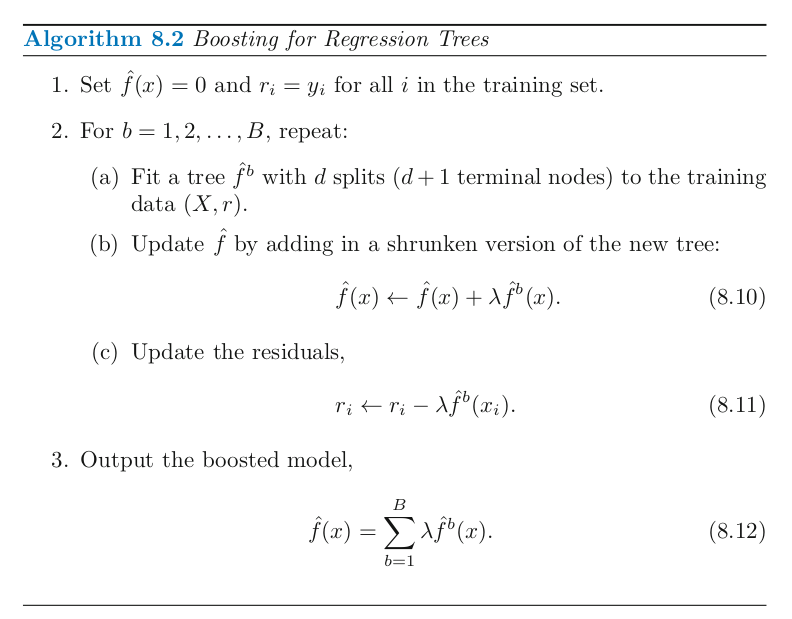

$$L_{MSE} = \frac{1}{2}(y - f(x))^2$$
$$e_m(x) = - \frac{dL}{f} = y - f(x)$$

### Bagging VS Boosting

Давайте сравним, как ведут себя бустинг и бэггинг с ростом числа базовых алгоритмов.

В случае бэггинга базовые алгоритмы независимо обучаются на бутстреп выборках из одного распределения. При этом некоторые из алгоритмов могут переобучиться, но при усреднии эффект переобучения снижается.

В случае бустинга каждый следующий алгоритм настраивается на ошибку предыдущего, что в свою очередь позволяет на каждом следующем шаге все аккуратнее выучивать исходное распределение. Однако при избыточном числе базовых алгоритмов градиентный бустинг может переобучиться, так как мы будем обучать все новые и новые деревья и слишком сильно подстроимся под обучающие данные.


Для иллюстрации сгенерируем "игрушечный датасет".

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

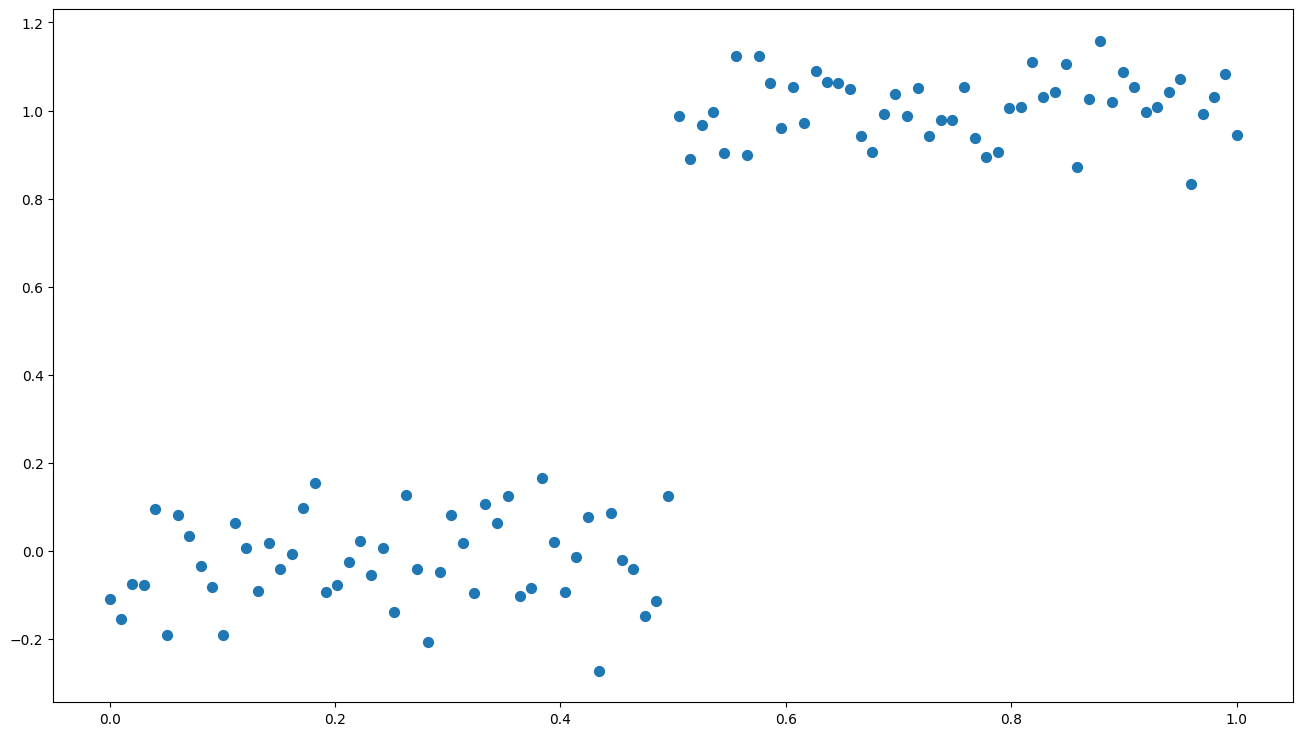

In [5]:
# создадим случайные точки
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)
plt.show()

## Bagging

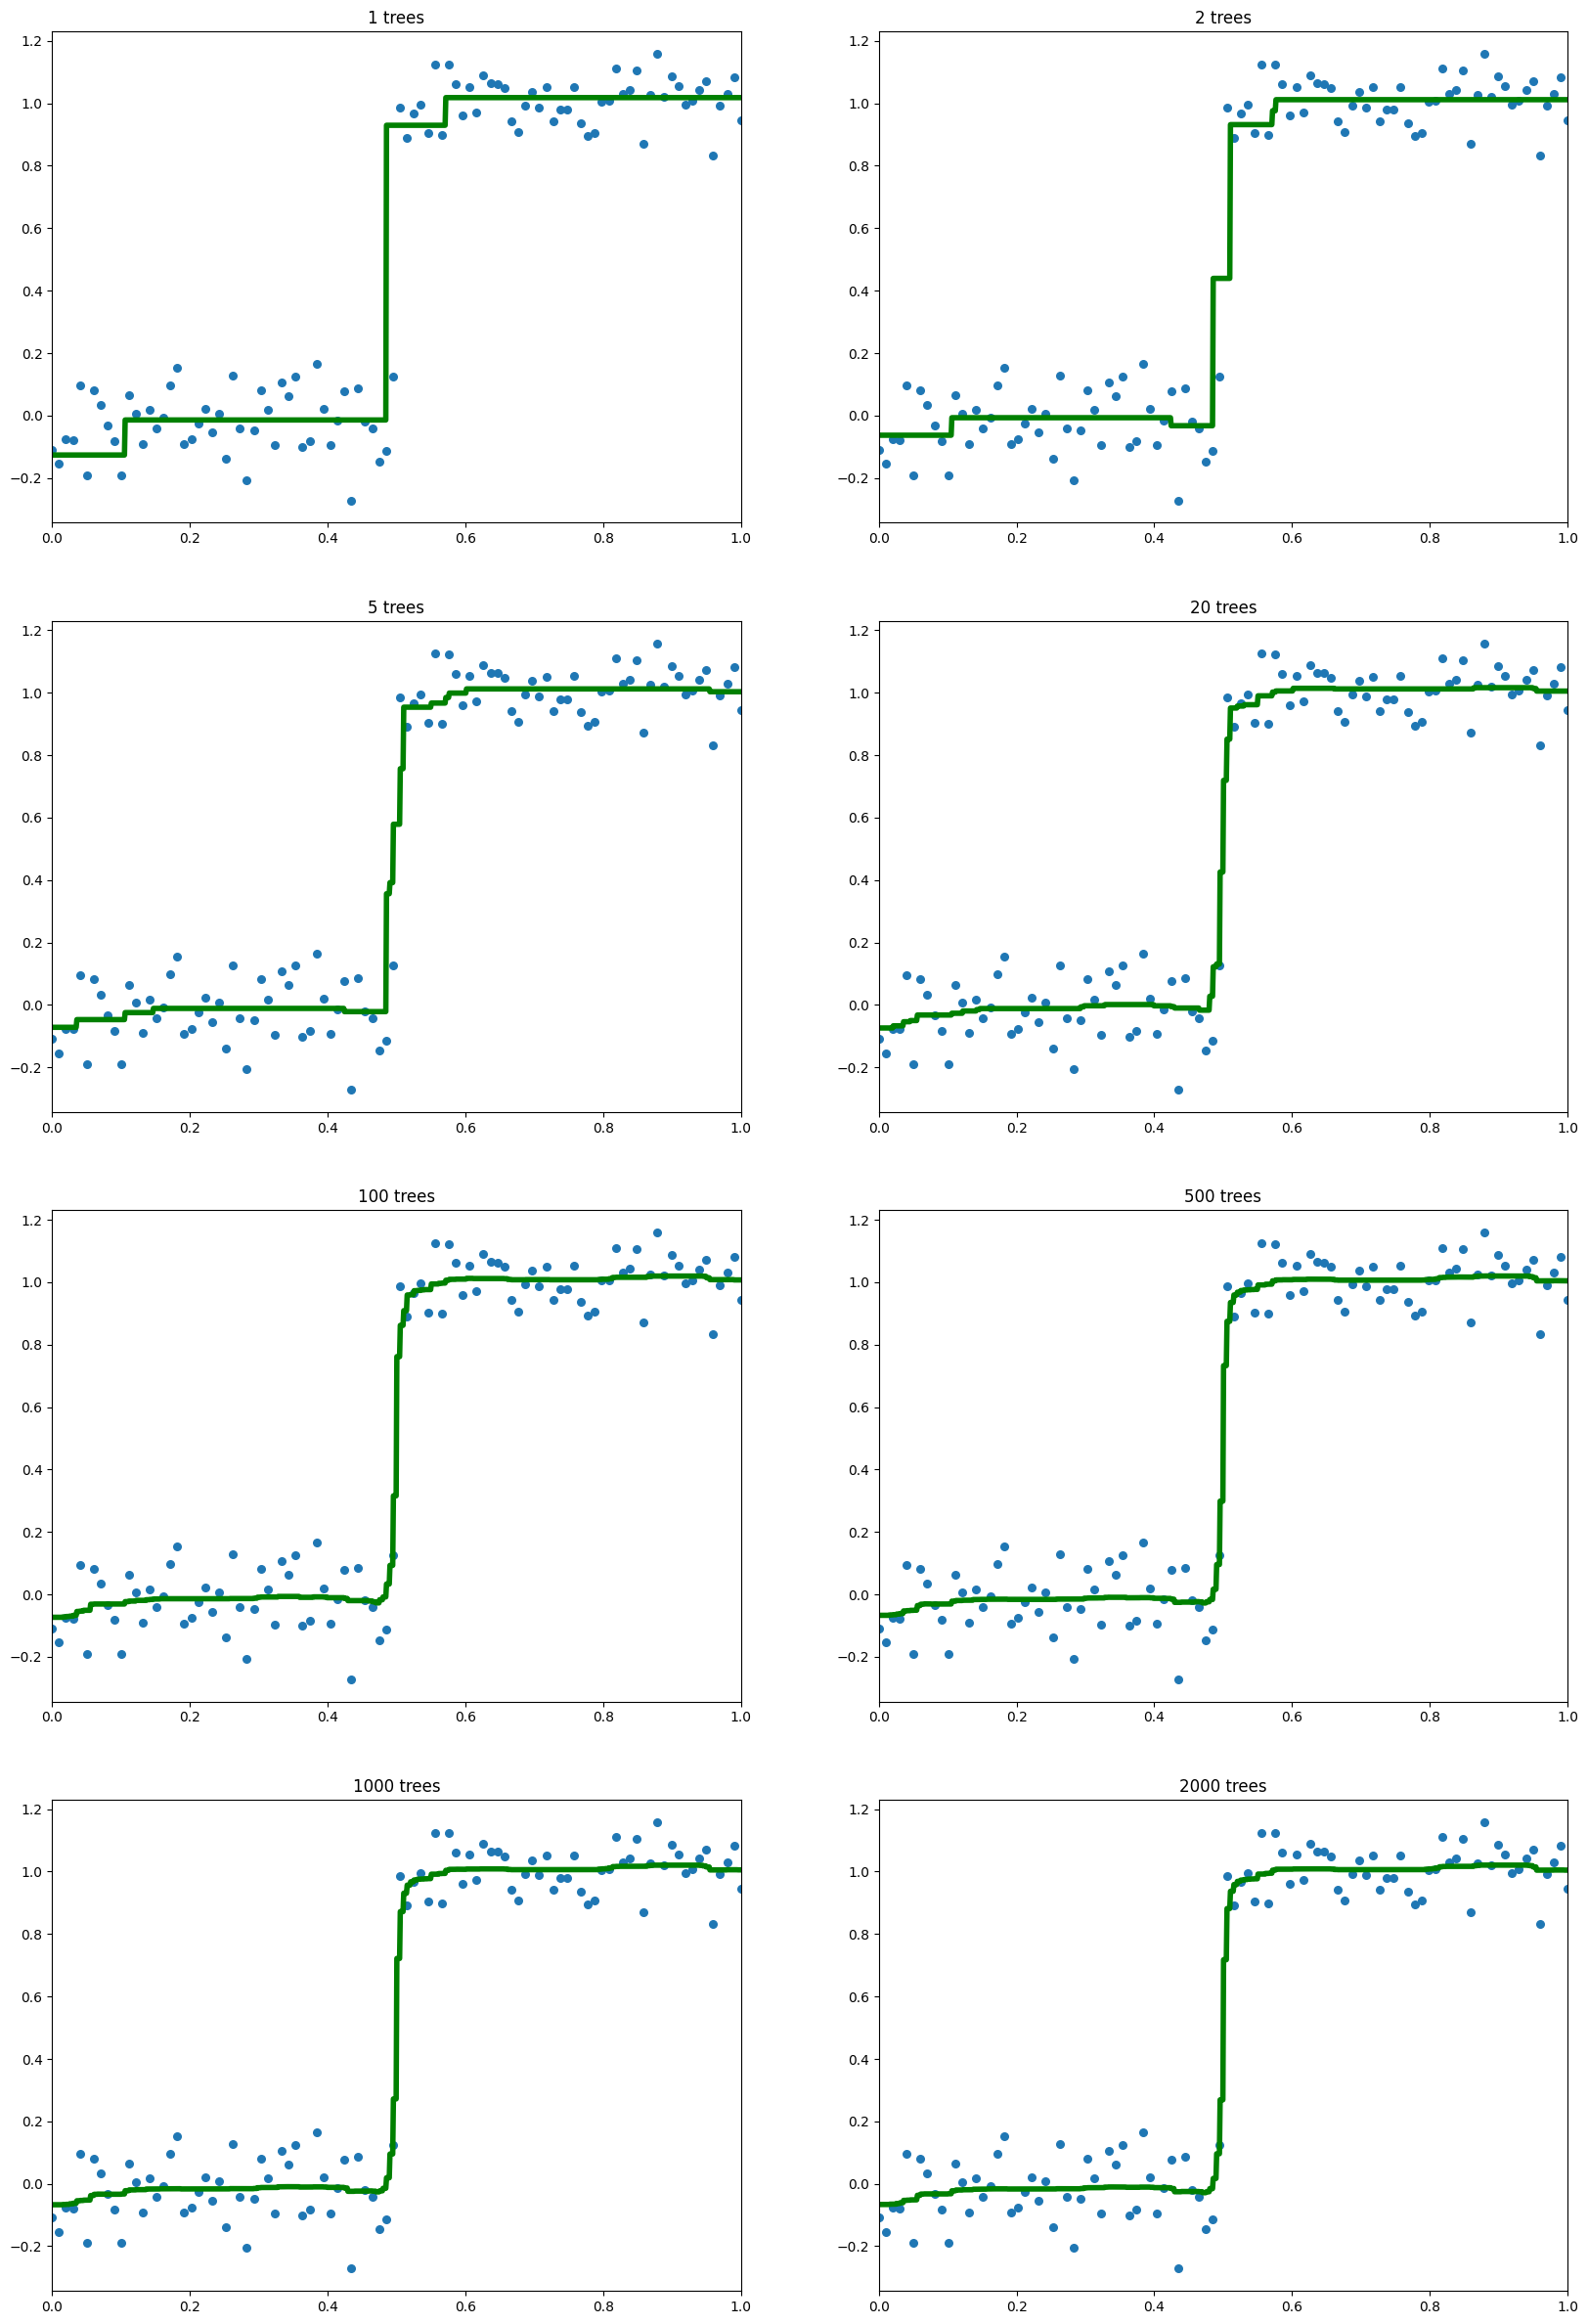

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))
plt.show()

## Вопрос: что происходит с увеличением деревьев? 

Мы видим, что с некоторого момента при увеличении числа деревьев итоговые ансамбль практически перестает изменятся.

## Boosting

Давайте посмотрим, как обстоит дело с бустингом.

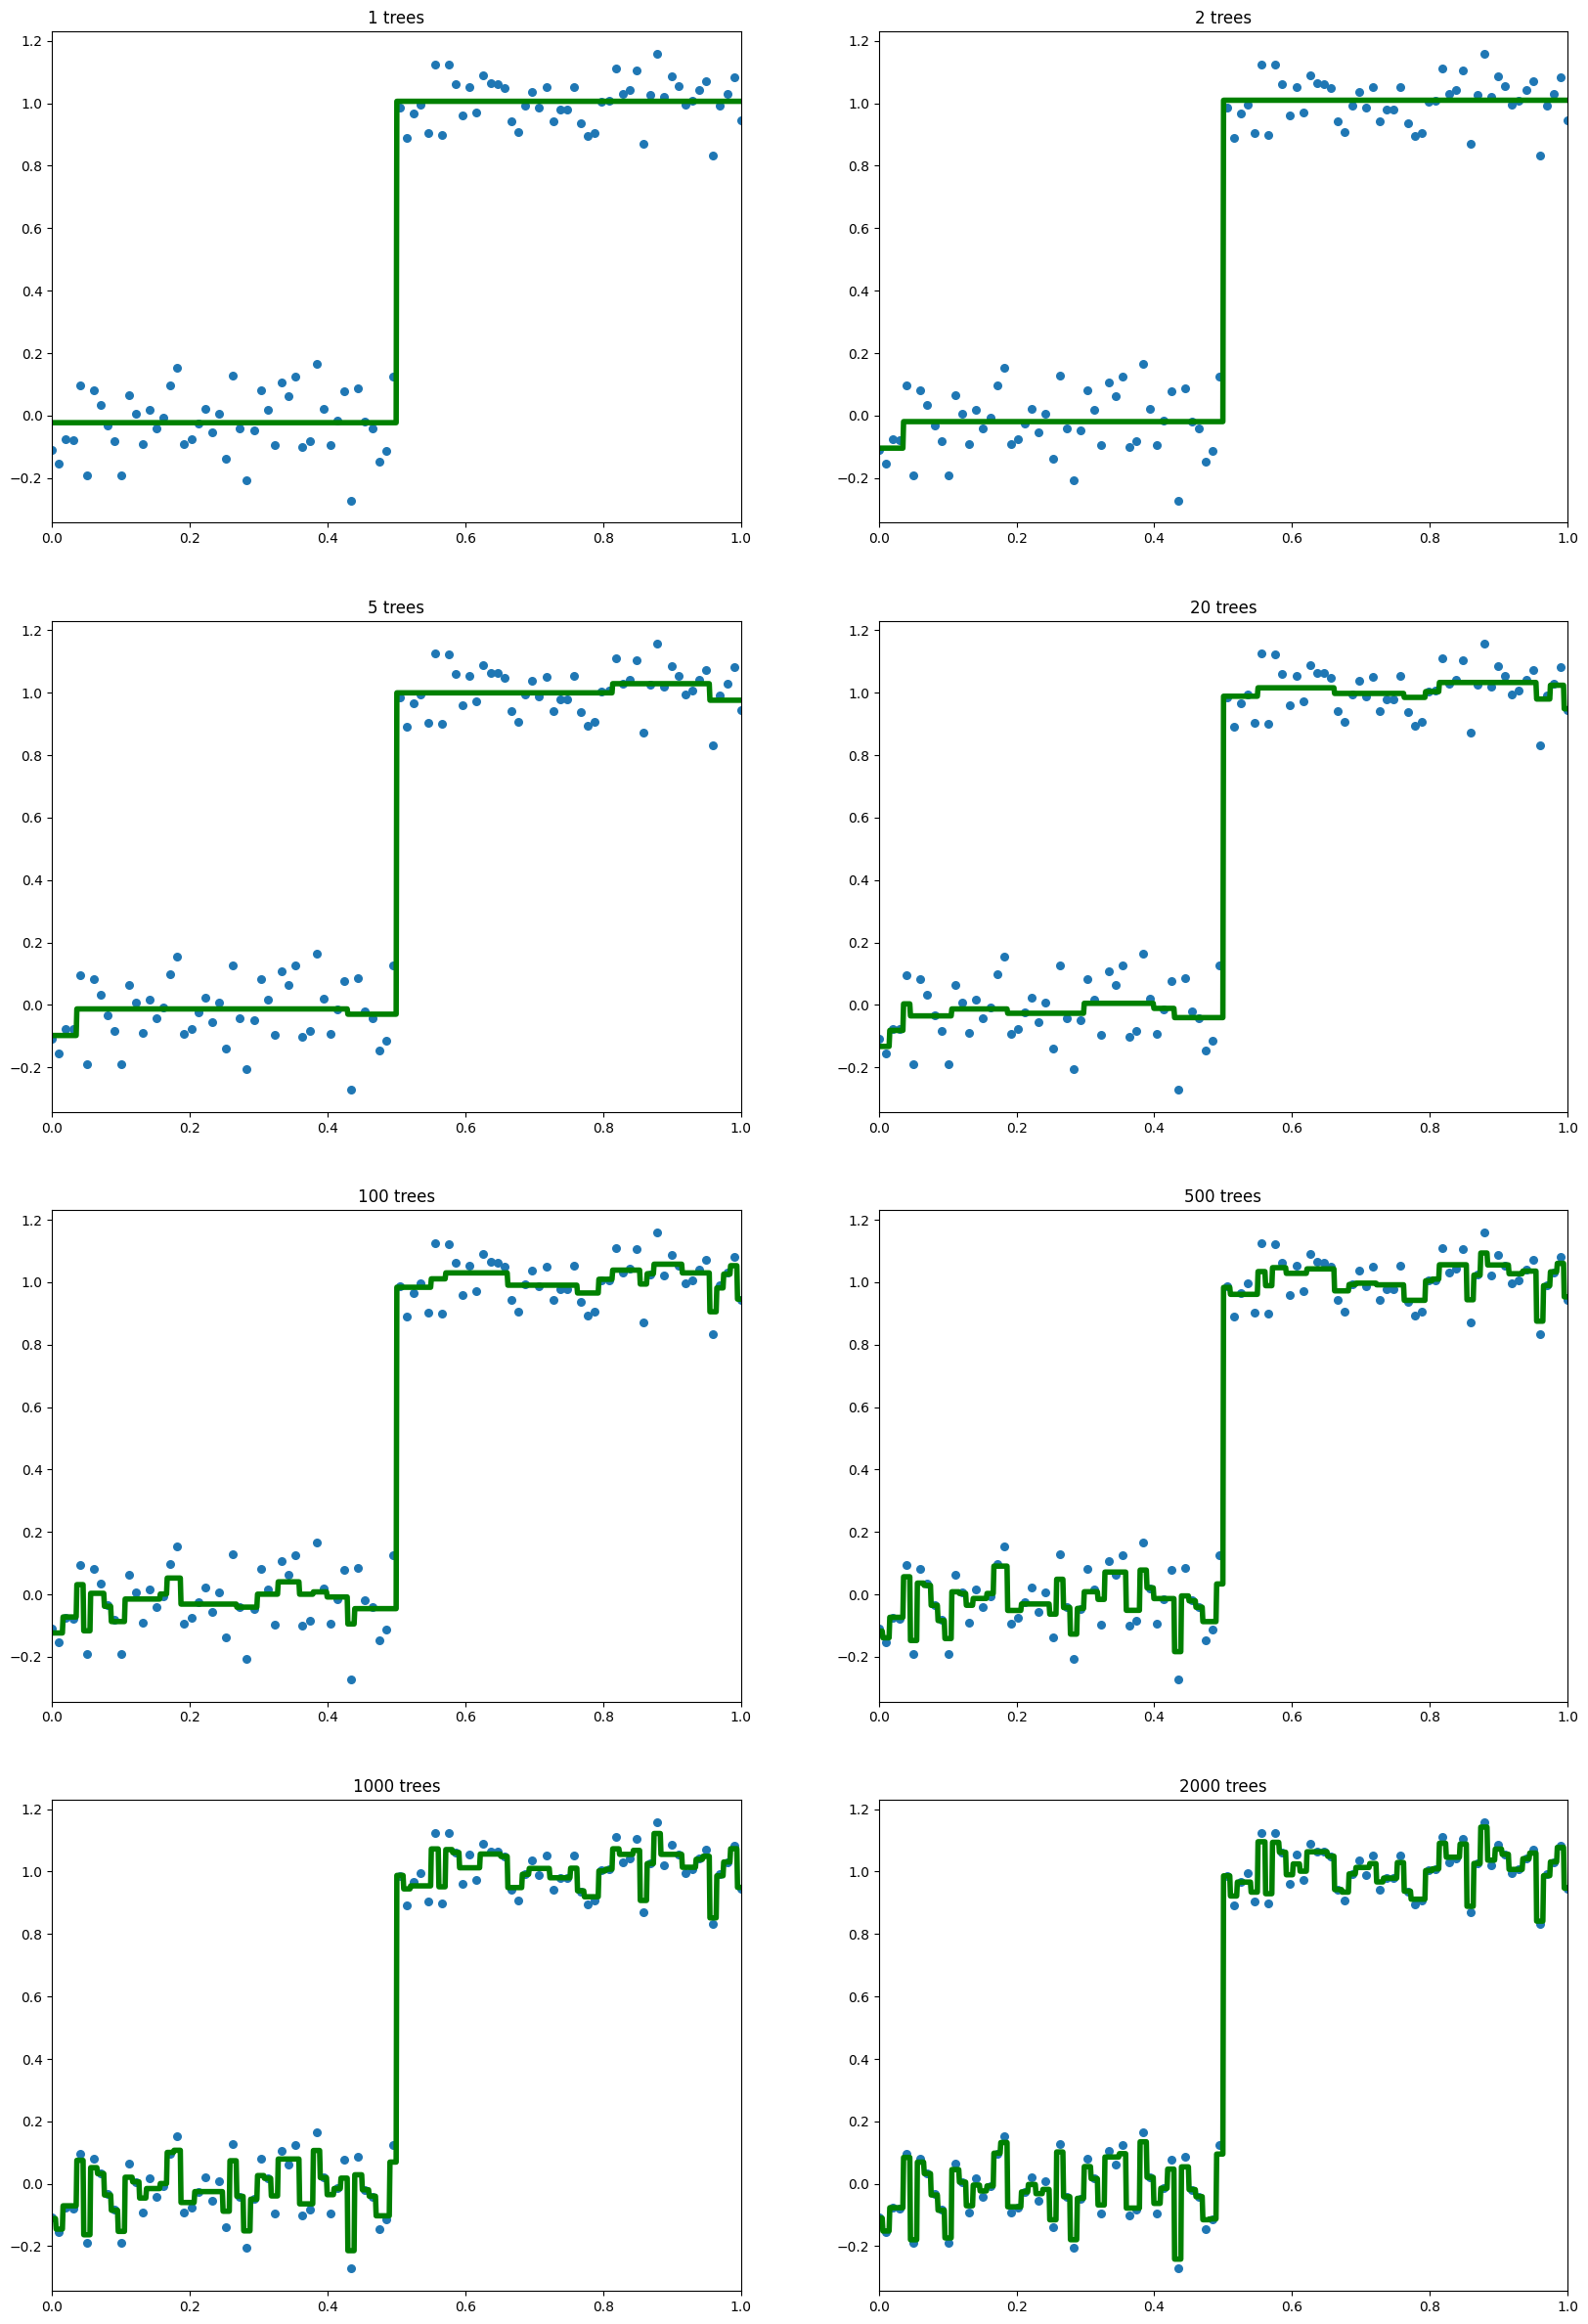

In [7]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))
plt.show()

## Вопрос: что происходит у увеличением деревьев? 

Градиентный бустинг очень быстро выучивает исходную зависимость, а затем начинает переобучаться, слишком сильно подстраиваясь под обучающие данные.

Чтобы избежать переобучения можно использовать очень простые базовые алгоритмы. Например, в градиентном бустинге часто используются **решающие пни** - деревья глубиной 1.

Другой способ - использовать затухающий learning rate. То есть для каждого следующего алгоритм уменьшать его вклад $\gamma$ в $\eta$ раз:

$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

Затухающий learning rate снижает скорость обучения, зато позволяет избежать переобучения. Однако даже при таком подходе градиентный бустинг все равно может переобучится для слишком большого числа алгоритмов при фиксированной $\eta$.

Поставим `learning_rate=0.1` и посмотрим, как изменится результат.

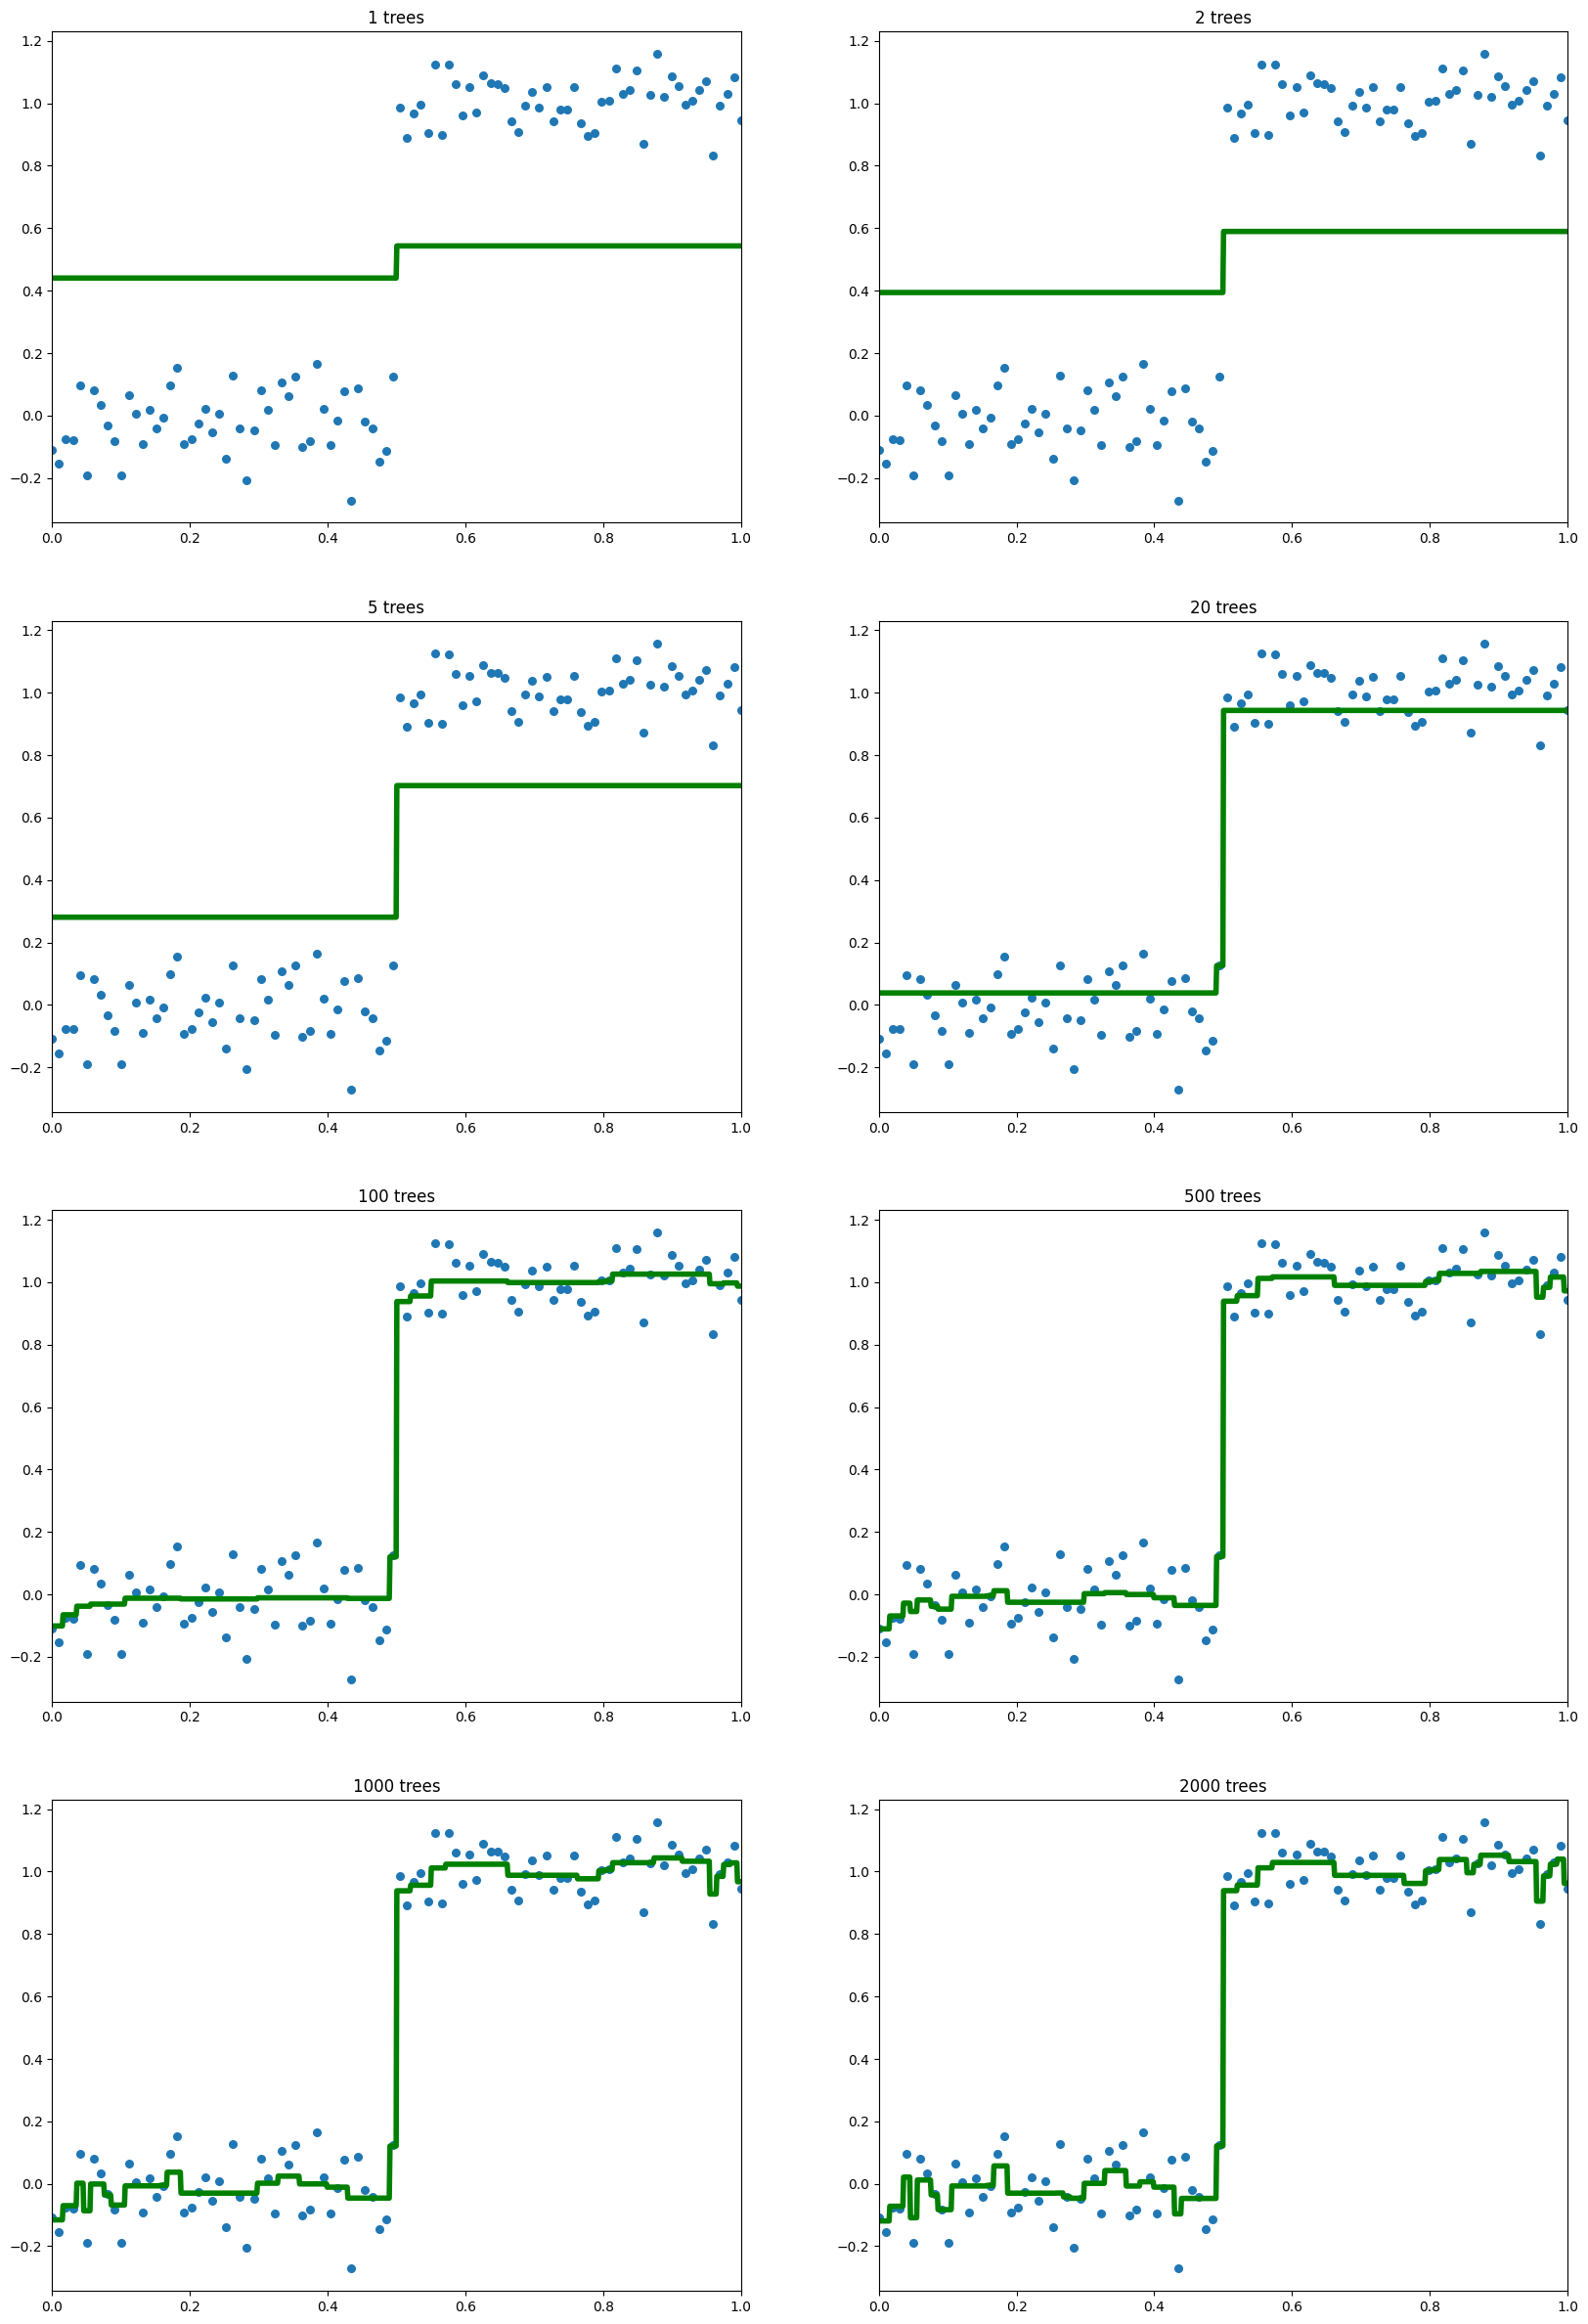

In [8]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Значительно лучше! Переобучение все еще есть, но уже не такое сильное.

## Теперь проведем эксперимент на реальных данных.
https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

In [9]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [10]:
ds = datasets.load_diabetes() # датасет с информацией пациентов с диабетом
df = pd.DataFrame(ds.data, columns=ds.feature_names)
df['target'] = ds.target
print(df.shape)
df.head()

(442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


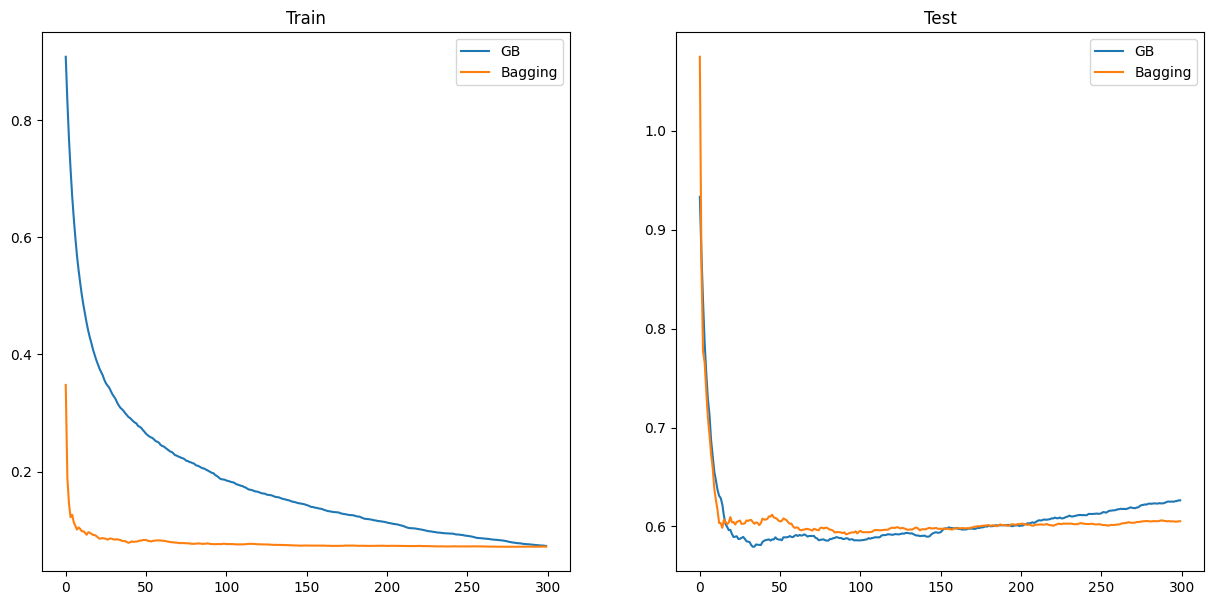

In [11]:
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

MAX_ESTIMATORS = 300

# BAGGING
gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))


    
# GB
gbclf = GradientBoostingRegressor(warm_start=True, max_depth=2, learning_rate=0.1)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))
    
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')
plt.gcf().set_size_inches(15,7)

## Gradient Boosting VS Random Forest

Сравним градиентный бустинг со случайным лесом на задании [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse):

Каждый пример описывает молекулу. 

Первая колонка содержит биологическую реакцию (целевая переменная):
- 1 - реакция была
- 0 - реакции не было

Оставшиеся столбцы (d1 - d1776) представляют собой молекулярные дескрипторы (molecular descriptors), отвечающие различным свойствам молекулы. Например, размер, форма и т. п. Матрица дескрипторов была предварительно нормализована.


In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

data = pd.read_csv('train.csv')

print(data.Activity.value_counts())
data.head()

Activity
1    2034
0    1717
Name: count, dtype: int64


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [14]:
y_test

array([1, 0, 1, ..., 0, 0, 0])

Обучим градиентный бустинг из коробки и посмотрим на скорость обучения.

In [15]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613            8.36s
         2           1.1722            8.70s
         3           1.1009            8.28s
         4           1.0528            8.11s
         5           1.0129            8.16s
         6           0.9739            8.07s
         7           0.9473            8.11s
         8           0.9194            8.11s
         9           0.9008            8.12s
        10           0.8814            8.04s
        20           0.7201            7.82s
        30           0.5950            7.81s
        40           0.5214            7.50s
        50           0.4482            7.11s
        60           0.3862            6.76s
        70           0.3427            6.45s
        80           0.3014            6.13s
        90           0.2723            5.78s
       100           0.2390            5.44s
       200           0.0787            2.38s
CPU times: user 11.3 s, sys: 8.9 ms, total: 11.3 s
Wal

Посмотрим, как влияет параметр learning_rate на качество алгоритма и склонность к переобучению.

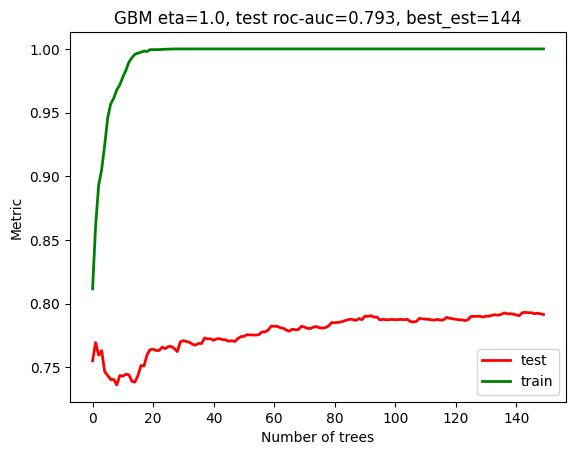

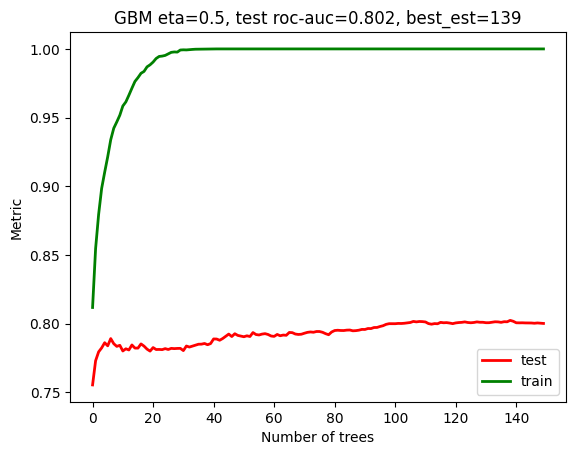

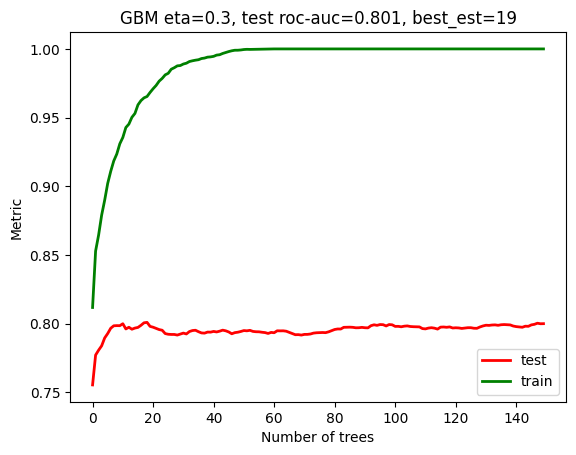

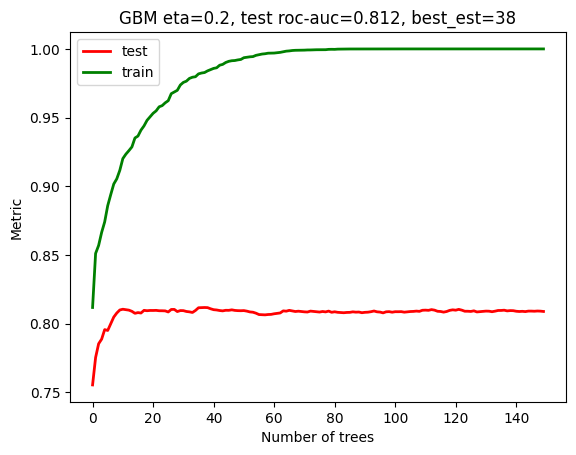

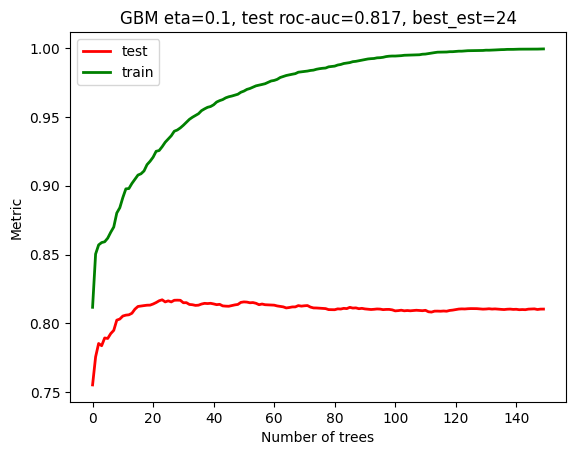

In [16]:
from sklearn.metrics import roc_auc_score

for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(n_estimators=150, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    l = roc_auc_score

    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = roc_auc_score(y_test, y_pred)
    
    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = roc_auc_score(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    
    plt.title('GBM eta=%.1f, test roc-auc=%.3f, best_est=%d' % (learning_rate, test_deviance.max(), test_deviance.argmax()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Metric')

Лучший ансамбль получается для $\eta = 0.1$. Он состоит из 24 базовых алгоритмов и достигает ROC-AUC = 0.817 на тесте. 

Теперь сравним качество со случайным лесом для того же числа деревьев (24 алгоритма).

In [17]:
rf = RandomForestClassifier(n_estimators=24, random_state=0).fit(X_train, y_train)
print ('Train RF ROC-AUC =', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
print ('Test RF ROC-AUC = ', roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Train RF ROC-AUC = 0.9999786482947104
Test RF ROC-AUC =  0.8037501166053144


Random Forest показывает качество ниже, чем GB. При этом он использует глубокие решающие деревья, что требует дополнительного времени обучения.

Для того чтобы достичь такого же качества как и GB, Random Forest потребуется намного больше деревьев.


In [18]:
for n_estimators in range(10, 101, 10):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train)
    print (n_estimators, 'trees: train ROC-AUC =',  roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]), 'test ROC-AUC =',  roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

10 trees: train ROC-AUC = 0.9986334908614701 test ROC-AUC = 0.7757621502737534
20 trees: train ROC-AUC = 0.9999928827649035 test ROC-AUC = 0.7999559590697408
30 trees: train ROC-AUC = 0.9999999999999999 test ROC-AUC = 0.8124681577795478
40 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8086632366764974
50 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8192958474156674
60 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8212400167911652
70 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8145100962262932
80 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8190884245007499
90 trees: train ROC-AUC = 0.9999999999999999 test ROC-AUC = 0.8211357447312337
100 trees: train ROC-AUC = 1.0 test ROC-AUC = 0.8215526087299707


В качестве бонуса можете посмотреть наглядную [визуализацию](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) градиентного бустинга.

## Современные библиотеки градиентного бустинга

В первой части занятия мы использовали наивную реализацию GB от scikit-learn, [предложенную](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) в Фридманом 1999. С того момента было предложено несколько более эффективных реализаций. На сегодняшний день существует 3 наиболее популярных библиотеки GB:
* **XGBoost**. После выхода библиотека очень быстро завоевала популярность и оставалась стандартом до появления LightGMB.

https://xgboost.ai/

* **LightGBM**. Отличительной чертой библиотеки является скорость обучения. LightGBM позволяет обучать модели намного быстрее по сравнению с XGBoost и при этом аналогичного качества. 

https://lightgbm.readthedocs.io/en/latest/

* **CatBoost**. Библиотека от Yandex. Ее отличительной чертой является автоматическая обработка категориальных фичей. Помимо этого, алгоритм менее чувствителен к выбору гиперпараметров и хорошо работает с гиперпараметрами "из коробки". 

https://catboost.ai/

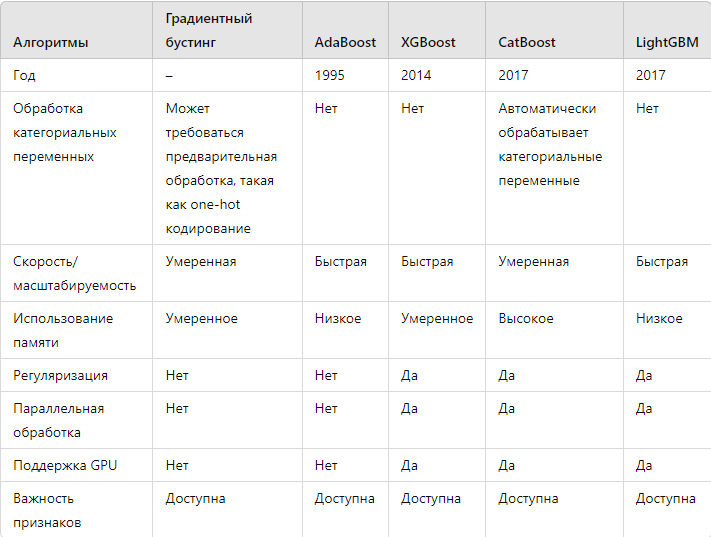

### Базовые гиперпараметры

(lightgbm/catboost)

* objective-the functionality that the composition will be configured for
* eta / learning_rate – learning rate
* num_iterations / n_estimators – number of boosting iterations

#### Гиперпараметры, отвечающие за сложность деревьев
* max_depth – maximum depth
* max_leaves / num_leaves – the maximum number of vertices in the tree
* gamma / min_gain_to_split-threshold for reducing the error function when splitting in the tree
* min_data_in_leaf – minimum number of objects in the sheet
* min_sum_hessian_in_leaf – the minimum sum of the weights of objects in the sheet, the minimum number of objects at which splitting is done
* lambda-regularization coefficient (L2)
* subsample / bagging_fraction – which part of the learning objects to use to build a single tree
* colsample_bytree / feature_fraction – which part of the features to use to build a single tree

Подбор гиперпараметров для градиентного бустинга - настоящее искусство. Как вариант, можно начать с наиболее важныж гиперпарамеров: learning_rate и n_estimators. Обычно мы фиксируем один из них и подбираем второй. Следующий по значимости параметр -  max_depth. Поскольку мы не хотим строить глубокие деревьев, то обычно этот параметр варьируют в пределах [3; 7].

In [28]:
# ! pip install lightgbm
# ! pip install --upgrade catboost==0.25


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement catboost==0.25 (from versions: 1.2, 1.2.1, 1.2.1.1, 1.2.2, 1.2.3, 1.2.5)
ERROR: No matching distribution found for catboost==0.25

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [19]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap

In [20]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

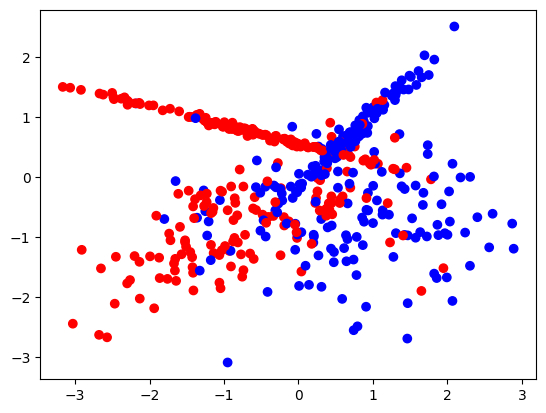

In [21]:
X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold);

## Catboost

In [ ]:
# ! pip list
# 2.1.0
# ! pip install numpy==1.26.4

In [22]:
from sklearn.metrics import *
from catboost import CatBoostClassifier 

0.919452347083926


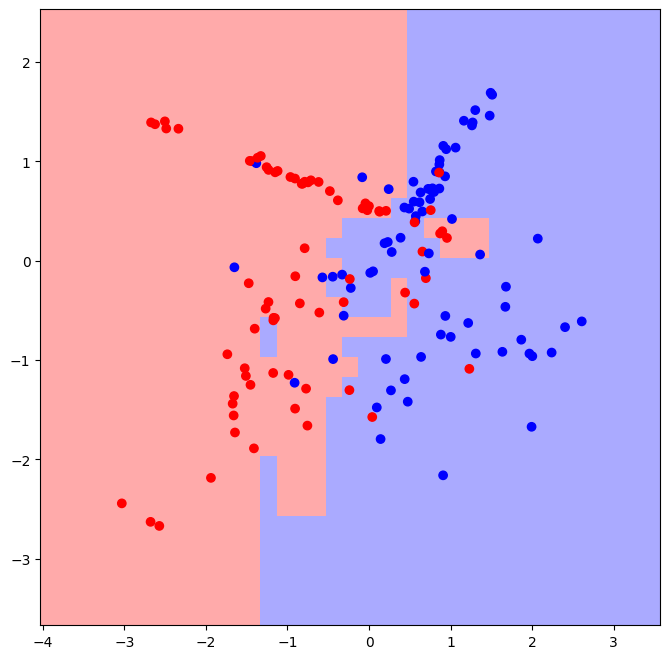

In [23]:
clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

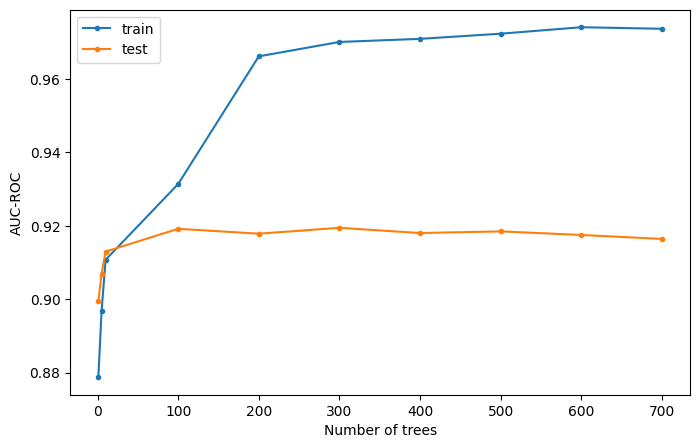

In [24]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

## LightGBM

0.8733108108108107


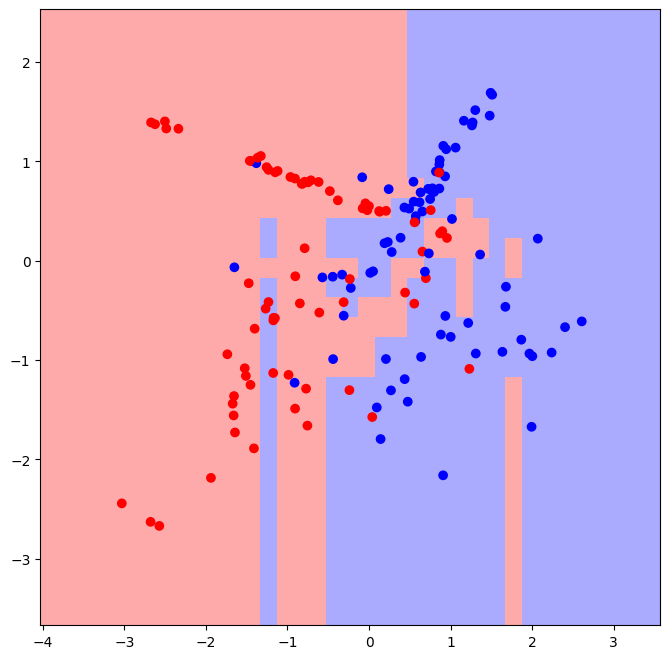

In [25]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=300, verbose=-1)
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

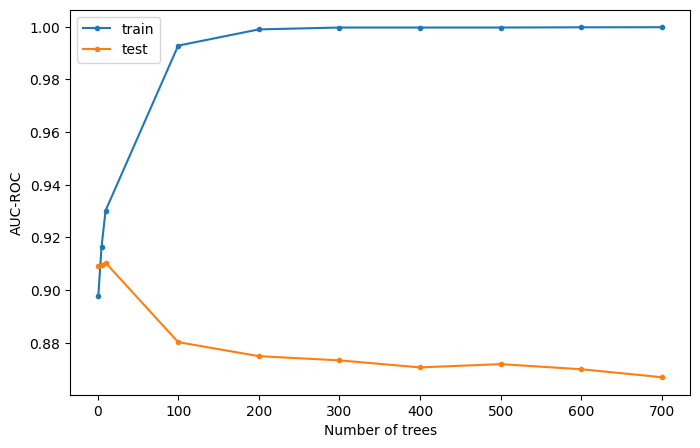

In [26]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []
for n in n_trees:
    clf = LGBMClassifier(n_estimators=n, verbose=-1)
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Зафиксируем число деревьев и будем варьировать их глубину.

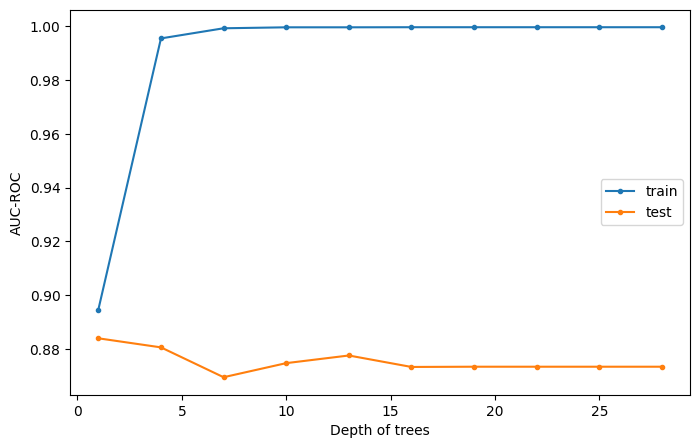

In [27]:
depth = list(range(1, 30, 3))
n_trees = 300
quals_train = []
quals_test = []
for d in depth:
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d, verbose=-1)
    lgb.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Сравним с Catboost:

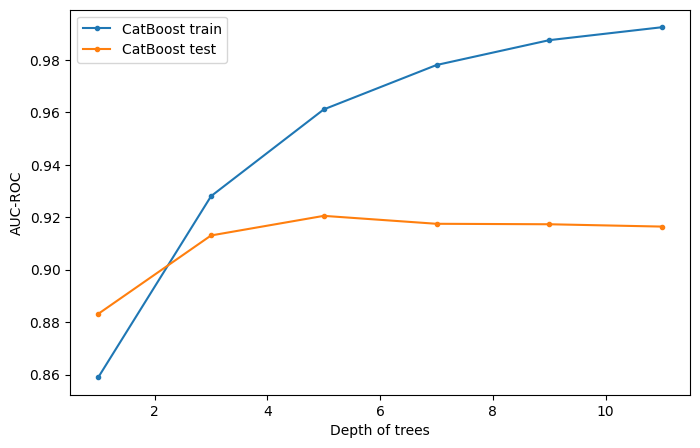

In [28]:
depth = list(range(1, 12, 2))
n_trees = 300
quals_cat_train = []
quals_cat_test = []
for d in depth:
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_cat_train.append(q_train)
    quals_cat_test.append(q_test)
    
plt.figure(figsize=(8, 5))
plt.plot(depth, quals_cat_train, marker='.', label='CatBoost train')
plt.plot(depth, quals_cat_test, marker='.', label='CatBoost test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

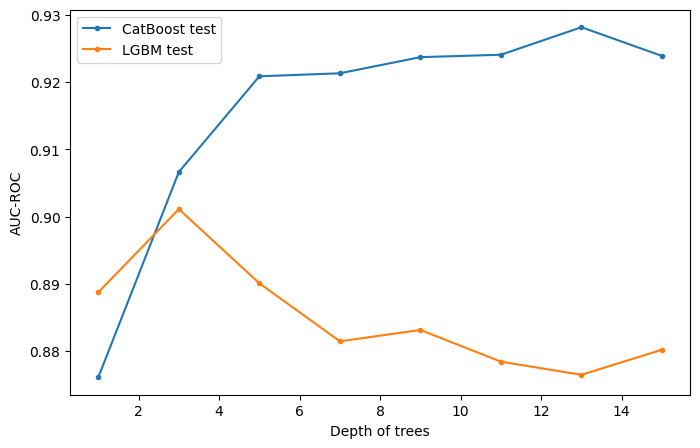

In [29]:
depth = list(range(1, 16, 2))
n_trees = 100
quals_cat_train = []
quals_cat_test = []
quals_lgbm_train = []
quals_lgbm_test = []
for d in depth:
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    q_cat_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_cat_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_cat_train.append(q_cat_train)
    quals_cat_test.append(q_cat_test)

    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d, verbose=-1)
    lgb.fit(X_train, y_train)
    q_lgbm_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_lgbm_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_lgbm_train.append(q_lgbm_train)
    quals_lgbm_test.append(q_lgbm_test)
    
plt.figure(figsize=(8, 5))
# plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_cat_test, marker='.', label='CatBoost test')
plt.plot(depth, quals_lgbm_test, marker='.', label='LGBM test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

In [30]:
print(f'{np.max(quals_cat_test):.3f}')

0.928


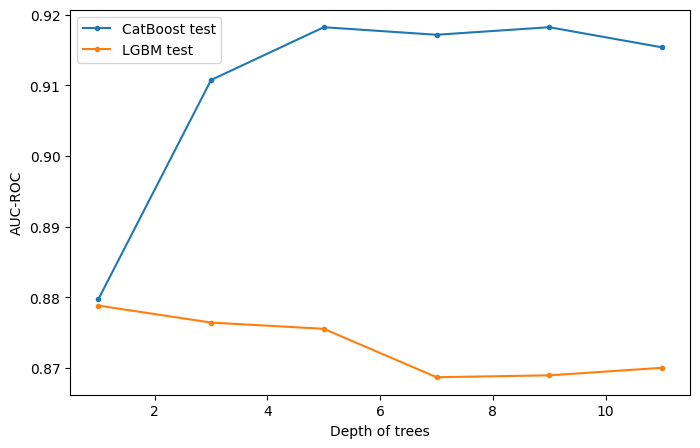

In [31]:
depth = list(range(1, 12, 2))
n_trees = 500
quals_cat_train = []
quals_cat_test = []
quals_lgbm_train = []
quals_lgbm_test = []
for d in depth:
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    q_cat_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_cat_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_cat_train.append(q_cat_train)
    quals_cat_test.append(q_cat_test)

    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d, verbose=-1)
    lgb.fit(X_train, y_train)
    q_lgbm_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_lgbm_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_lgbm_train.append(q_lgbm_train)
    quals_lgbm_test.append(q_lgbm_test)
    
plt.figure(figsize=(8, 5))
# plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_cat_test, marker='.', label='CatBoost test')
plt.plot(depth, quals_lgbm_test, marker='.', label='LGBM test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

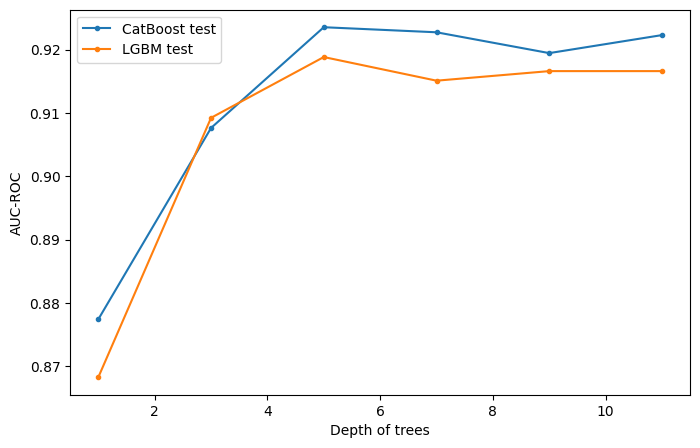

In [32]:
depth = list(range(1, 12, 2))
n_trees = 20
quals_cat_train = []
quals_cat_test = []
quals_lgbm_train = []
quals_lgbm_test = []
for d in depth:
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    q_cat_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_cat_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_cat_train.append(q_cat_train)
    quals_cat_test.append(q_cat_test)

    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d, verbose=-1)
    lgb.fit(X_train, y_train)
    q_lgbm_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_lgbm_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_lgbm_train.append(q_lgbm_train)
    quals_lgbm_test.append(q_lgbm_test)
    
plt.figure(figsize=(8, 5))
# plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_cat_test, marker='.', label='CatBoost test')
plt.plot(depth, quals_lgbm_test, marker='.', label='LGBM test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

In [33]:
np.max(quals_cat_test)

0.9235419630156473

In [34]:
np.max(quals_lgbm_test)

0.9188300142247511

**Не забудьте сохранить модели после обучения, чтобы наши труды не пропали даром!**

In [35]:
lgb.booster_.save_model('lightgbm.txt')

clf.save_model('catboost.cbm', format='cbm')

Потом можно их загрузить следующим образом:

In [36]:
lgb = LGBMClassifier(model_file='mode.txt')

clf = clf.load_model('catboost.cbm')